In [1]:
import numpy as np
import sympy as sp
import matplotlib
import random
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
%matplotlib inline 
%precision 5

'%.5f'

## Boundary value problem 

Consider a square domain $(x,y)\in \Omega = [0, 1]\times [0,1]$. Only dirichlet boundary conditions are considered in this example. At the left boundary consider $\theta=0$ and at the right side consider $\theta=1$. On the top and botom sides we have $\theta=x^2$. There is a source term $s(\theta) = -6\theta$, and the conductivity is $k(\theta)=\theta)$. The problem is the find $\theta \in \Omega$ such that 

$k(\theta) \nabla_x \theta + s(\theta) = 0 \in \Omega$ 

with the conductivity and source terms defined above $k(\theta) = \theta, s(\theta) = -6\theta$ and with the boundary conditions specified above, i.e. known $\theta$ on all boundaries $\partial \Omega$. 

### Weak form

The weak form of this problem leads to the following integral that needs to be calculated for every element 

$\int_{\Omega^e} \mathbf{q}\cdot \nabla_x w\,  d\Omega^e + \int_{\Omega^e} s\, w \, d\Omega^e$ 

where $\mathbf{q} = -k(\theta)\nabla_x \theta$ is the flux, which depends on the unknown scalar field $\theta$, and $s(\theta)$ is the source term, which also depends on the unknown field $\theta$. The weight function is $w$. 

### Residual

This integral, upon introducing the dicrete weight function $w^h = \sum N_i^e w_i^e$ and taking the nodal values of the weight function $w_i^e$ out of the integral, leads to the residual vector 

$R^e_a = \int_{\Omega^e} \mathbf{q}(\theta^h) \cdot \nabla_x N_a^e \, d\Omega^e + \int_{\Omega^e} s(\theta^h) N_a^e \, d\Omega^e$ 

for each node $a=1,2,3,4$. 

### Tangent


Linearization of the residual in the direction of the increment $\Delta \theta$ and substitution of the discrete increment lead to the tangent matrix $\mathbf{K}^e$ for the element, which is the $4\times 4$ matrix needed for the Newton-Raphson iterations as will be seen in this notebook 

$K_{ab}^e = \int_{\Omega^e} \left(-\frac{d \, k(\theta)}{d\, \theta}\, N_b^e \, \nabla_x\theta \cdot \nabla_x N_a^e \right)d\Omega^e + \int_{\Omega^e} -k(\theta) \nabla_x N_b^e \cdot \nabla_x N_a^e d\Omega^e  + \int_{\Omega^e} \left(\frac{d\, s(\theta)}{d\, \theta}\, N_b^e \, N_a^e \right) d\Omega^e $



 

## Mesh 

Consider a simple mesh made out of 5 quadrilateral elements and 8 nodes. 

In [2]:
n_node = 8
n_elem = 5
node_x = np.array([[0.,0.],[0.,1.],[1.,1.],[1.,0.],
                   [0.27,0.25],[0.75,0.27],[0.73,0.75],[0.25,0.73]])
elements = np.array([[0,3,5,4],[3,2,6,5],[2,1,7,6],[1,0,4,7],[4,5,6,7]])

# for the homework the best strategy is to add a mesh for boundary 
n_boundary_e = 1
boundary_elements = np.array([[3,2]])

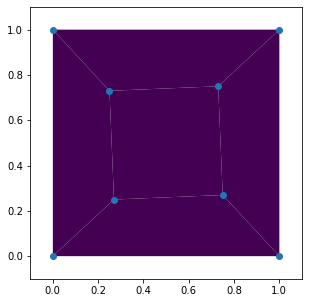

In [80]:
## PLOT THETA 
f, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(5,5))
ax1.set_xlim([-0.1, 1.1])
ax1.set_ylim([-0.1, 1.1])
ax1.set_aspect('equal')
patches1 = []
colors1 = np.zeros((n_elem))
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = 0.0
p1 = PatchCollection(patches1)
p1.set_array(colors1)
ax1.add_collection(p1)
ax1.scatter(node_x[:,0],node_x[:,1])



## Newton Raphson solution 

We start with a guess for the solution. Clearly, this guess has to satisfy the essential boundary conditions. 
For each iteration of the Newton Raphson, the total residual and total tangent are needed. For that, a loop over the elements of the mesh is done. Inside of this loop, the residual and tangent for an individual element is calculated and then *assembled* into the global residual and tangent. The residual and tangent are used to compute the increment. The increment is used to update our guess. The Newton-Loop continues until convergence. 

In [5]:
# Definition of the shape function and the derivative with respect to parent domain xi

def Nvec(xi,eta):
    return 0.25*np.array([(1-xi)*(1-eta),(1+xi)*(1-eta),(1+xi)*(1+eta),(1-xi)*(1+eta)])

def dNvecdxi(xi,eta):
    return 0.25*np.array([[(-1)*(1-eta),(+1)*(1-eta),(+1)*(1+eta),(-1)*(1+eta)],\
                          [(1-xi)*(-1),(1+xi)*(-1),(1+xi)*(+1),(1-xi)*(+1)]])

# For the flux use 1D functions 
def N1D(xi):
    return 0.5*np.array([(1-xi),(1+xi)])

def dN1Ddxi(xi):
    return 0.5*np.array([-1.0,1.0])

In [6]:
# First guess for the Newton Raphson algorithm, remember it needs to satisfy the essential boundary conditions 
# for homework, only essential boundary conditions on the left end
node_th = np.zeros((n_node))
for ni in range(n_node):
    if node_x[ni,0] >0.00001:
        node_th[ni] = 1.0 
        
# create the flux over the nodes, not the best because in this case the bottom and top
# are on the boundary with natural boundary conditions but they have zero flux, this
# type of array would not work because it would lead non-zero flux on the bottom and top 
node_qn = np.array([0.0,0.0,-2.0,-2.0,0.0,0.0,0.0,0.0])

In [7]:


#----------------------#
# NEWTON LOOP
#----------------------#
res = 1
iter = 0
itermax = 20
tol = 1e-5
while res>tol and iter<itermax:
    # INITIALIZE GLOBAL RESIDUAL AND TANGENT
    RR = np.zeros((n_node))
    KK = np.zeros((n_node,n_node))
    #----------------------#
    # LOOP OVER ELEMENTS
    #----------------------#
    for ei in range(n_elem):
        # node coordinates 
        node_ei = elements[ei]
        x1e = node_x[node_ei[0]]
        x2e = node_x[node_ei[1]]
        x3e = node_x[node_ei[2]]
        x4e = node_x[node_ei[3]]
        # nodal values for the field theta
        th1e = node_th[node_ei[0]]
        th2e = node_th[node_ei[1]]
        th3e = node_th[node_ei[2]]
        th4e = node_th[node_ei[3]]
        #------------------------------#
        # LOOP OVER INTEGRATION POINTS
        #------------------------------#
        # integration points (using 2x2 Gauss quadrature in the parent domain)
        IP_xi = np.array([[-1./np.sqrt(3),-1./np.sqrt(3)],[+1./np.sqrt(3),-1./np.sqrt(3)],\
                              [+1./np.sqrt(3),+1./np.sqrt(3)],[-1./np.sqrt(3),+1./np.sqrt(3)]])
        IP_wi = np.array([1.,1.,1.,1.])
        # Initialize the ELEMENT residual to a vector of zeros 
        Re = np.zeros((4)) # note the size of the residual is the number of nodes 
        # Initialize the ELEMENT tangent to a matrix of zeros 
        Ke = np.zeros((4,4))
        # this is where the actual loop starts 
        for ip in range(4):
            xi  = IP_xi[ip,0]
            eta = IP_xi[ip,1]
            wip = IP_wi[ip]
            # evaluate the isoparametric map 
            Ns = Nvec(xi,eta)
            x = Ns[0]*x1e + Ns[1]*x2e + Ns[2]*x3e + Ns[3]*x4e 
            # evaluate the Jacobian 
            dNsdxi = dNvecdxi(xi,eta)
            dxdxi = np.outer(x1e,dNsdxi[:,0])+np.outer(x2e,dNsdxi[:,1])+np.outer(x3e,dNsdxi[:,2])+np.outer(x4e,dNsdxi[:,3])
            # get gradient of basis function with respect to x using inverse jacobian 
            JinvT = np.linalg.inv(dxdxi).transpose()
            dNsdx = np.dot(JinvT,dNsdxi)
            # evaluate the field theta_h at integration point 
            theta = Ns[0]*th1e + Ns[1]*th2e + Ns[2]*th3e + Ns[3]*th4e 
            # evaluate the gradient of theta_h with respect to coordinates x 
            gradx_theta = th1e*dNsdx[:,0]+th2e*dNsdx[:,1]+th3e*dNsdx[:,2]+th4e*dNsdx[:,3]
            # evaluate the conductivity 
            k = theta 
            # evaluate the source 
            s = -6.0*theta
            #------------------------------#
            # INTEGRATE THE RESIDUAL
            # for the homework, add flux!! 
            #------------------------------#
            Re[0] +=  wip*np.linalg.det(dxdxi)*(k*np.dot(gradx_theta,dNsdx[:,0]) - s*Ns[0] )
            Re[1] +=  wip*np.linalg.det(dxdxi)*(k*np.dot(gradx_theta,dNsdx[:,1]) - s*Ns[1] )
            Re[2] +=  wip*np.linalg.det(dxdxi)*(k*np.dot(gradx_theta,dNsdx[:,2]) - s*Ns[2] )
            Re[3] +=  wip*np.linalg.det(dxdxi)*(k*np.dot(gradx_theta,dNsdx[:,3]) - s*Ns[3] ) 
            # for the tangent a couple of derivatives needed first 
            dkdtheta = 1.0 
            dsdtheta = -6.0
            #------------------------------#
            # INTEGRATE THE TANGENT
            #------------------------------#
            # easier to do in two for loops, both are over the nodes, remember that the residual 
            # has four entries because there are four shape functions, which we referred to N_a 
            # When we did the linearization and plugged in the discrete increment we intriduced
            # additional shape functions N_b, where b=1,2,3,4 because there are four nodes 
            for a in range(4):
                for b in range(4):
                    Ke[a,b] +=  wip*np.linalg.det(dxdxi)*(dkdtheta*Ns[b]*np.dot(gradx_theta,dNsdx[:,a])\
                                                          +k*np.dot(dNsdx[:,b],dNsdx[:,a]) - dsdtheta*Ns[a]*Ns[b] )
        #------------------------------#
        # ASSEMBLE INTO GLOBAL RR, KK
        #------------------------------#
        # Here again it is convenient to have a loop over nodes of the element
        for a in range(4):
            RR[node_ei[a]] += Re[a]
            for b in range(4):
                KK[node_ei[a],node_ei[b]] += Ke[a,b]
    
    #-------------------------------------------#
    # Fill in the flux residual 
    #-------------------------------------------#
    # start with initial flux of zeros 
    RRq = np.zeros((n_node))
    for ei in range(n_boundary_e):
        # node coordinates for the boundary elements
        node_ei = boundary_elements[ei]
        x1e = node_x[node_ei[0]]
        x2e = node_x[node_ei[1]]
        # nodal values for the flux,
        # note, this is not optimal, the way I have it right now there is a single
        # flux per node, but that would not work in all cases, it works here because
        # the only element that Im considering as a boundary element is the right
        # if the mesh was fine enough then this would work, but for the current mesh
        # the best would probably be to have not a single flux per node but a single
        # flux per node per boundary element
        q1e = node_qn[node_ei[0]]
        q2e = node_qn[node_ei[1]]
        # length of the edge 
        le = np.linalg.norm(x2e-x1e)
        #------------------------------#
        # LOOP OVER INTEGRATION POINTS
        #------------------------------#
        # integration points in 1D
        IP_xi = np.array([-1./np.sqrt(3),+1./np.sqrt(3)]) 
        IP_wi = np.array([1.,1.])
        # Initialize the ELEMENT residual to a vector of zeros 
        Req = np.zeros((2)) # note the size of the residual is the number of nodes 
        for ip in range(2):
            xi = IP_xi[ip]
            wip = IP_wi[ip]
            qn = N1D(xi)[0]*q1e + N1D(xi)[1]*q2e
            # the isoparametric map over the edge is in a local 
            # coordinate system such that sx1e = 0, sx2e = le
            # and sx = N1*0 + N2*le = N2*le 
            sx = N1D(xi)[1]*le
            # the corresponding Jacobian 
            dsxdxi = dN1Ddxi(xi)[1]*le
            # the integral 
            Req[0] += wip*dsxdxi*qn*N1D(xi)[0]
            Req[1] += wip*dsxdxi*qn*N1D(xi)[1]
        #------------------------------#
        # ASSEMBLE INTO GLOBAL RRq
        #------------------------------#
        RRq[node_ei[0]]+=Req[0]    
        RRq[node_ei[1]]+=Req[1]
    
    #-------------------------------------------#
    # PARTITION, ONLY RR FROM NODES WITHOUT EBC
    #-------------------------------------------#
    RR_dof = RR[2:] + RRq[2:] # ignore the first 2 nodes, i.e. ignore 0,1 
    KK_dof = KK[2:,2:] # ignore the corresponding rows and columns in KK 
    
    #------------------------------#
    # NEWTON STEP
    #------------------------------#
    res = np.linalg.norm(RR_dof)
    th_incr = np.linalg.solve(KK_dof,RR_dof)
    # note, the increment is only for nodes which are not in the EBC 
    node_th[2:] -= th_incr 
    iter+=1
    print('iteration %i'%iter)
    print('residual %f'%res)



iteration 1
residual 3.350617
iteration 2
residual 0.809665
iteration 3
residual 0.125524
iteration 4
residual 0.011850
iteration 5
residual 0.000178
iteration 6
residual 0.000000


## Plot

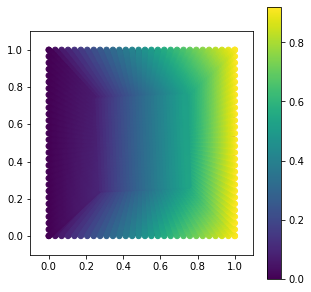

In [8]:
f, (ax1) = plt.subplots(1, 1, sharey=True,figsize=(5,5))
ax1.set_xlim([-0.1, 1.1])
ax1.set_ylim([-0.1, 1.1])
ax1.set_aspect('equal')
patches1 = []
colors1 = np.zeros((n_elem))
theta_vec_e = []
x_vec_e = []
y_vec_e = []
for i in range(n_elem):
    n1 = elements[i,0]
    n2 = elements[i,1]
    n3 = elements[i,2]
    n4 = elements[i,3]
    x1e = node_x[n1]
    x2e = node_x[n2]
    x3e = node_x[n3]
    x4e = node_x[n4]
    th1e = node_th[n1]
    th2e = node_th[n2]
    th3e = node_th[n3]
    th4e = node_th[n4]
    polygon = Polygon([node_x[n1],node_x[n2],node_x[n3],node_x[n4]], closed=True)
    patches1.append(polygon)
    colors1[i] = 0.0
    # create a scatter plot by sampling over the parent domain 
    theta_vec = np.zeros((900))
    x_vec = np.zeros((900,2))
    for ii in range(30):
        for jj in range(30):
            xi = -1 + ii/29.*2 
            eta = -1 + jj/29.*2 
            Ns = Nvec(xi,eta)
            x_vec[ii*30+jj] = Ns[0]*x1e + Ns[1]*x2e + Ns[2]*x3e + Ns[3]*x4e 
            theta_vec[ii*30+jj]= Ns[0]*th1e + Ns[1]*th2e + Ns[2]*th3e + Ns[3]*th4e 
    theta_vec_e.append(theta_vec)
    x_vec_e.append(x_vec[:,0])
    y_vec_e.append(x_vec[:,1])


p1 = PatchCollection(patches1)
p1.set_array(colors1)
ax1.add_collection(p1)

x_vec_all = np.stack((x_vec_e[0],x_vec_e[1],x_vec_e[2],x_vec_e[3],x_vec_e[4]))
y_vec_all = np.stack((y_vec_e[0],y_vec_e[1],y_vec_e[2],y_vec_e[3],y_vec_e[4]))
th_vec_all = np.stack((theta_vec_e[0],theta_vec_e[1],theta_vec_e[2],theta_vec_e[3],theta_vec_e[4]))

sc = ax1.scatter(x_vec_all,y_vec_all,c=th_vec_all,s=30)
plt.colorbar(sc,ax=ax1)